In [1]:
import os
import csv
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import regularizers

Using TensorFlow backend.


In [2]:
def read_csv(directory):
    with open(directory + '/driving_log.csv', 'r') as csvfile:
        steerings = []
        filtered_steerings = []
        filtered_lines = []
        reader = csv.reader(csvfile)
        steering_limit = 0.0
        
        for i, line in enumerate(reader):
            if i != 0:
                steering = float(line[3])
                steerings.append(steering)

                if abs(steering) >= steering_limit:
                    filtered_lines.append(line)
                    filtered_steerings.append(steering)
    
        return filtered_lines, steerings, filtered_steerings

def split_on_batches(train_samples, valid_samples, size=64):
    train_lines_num = len(train_samples)
    train_batches = train_lines_num // size
    train_samples_num = size * train_batches
    train_csv_lines = train_samples[:train_samples_num]
    train = train_csv_lines, train_batches

    valid_lines_num = len(valid_samples)
    valid_batches = valid_lines_num // size
    valid_samples_num = size * valid_batches
    valid_csv_lines = valid_samples[:valid_samples_num]
    valid = valid_csv_lines, valid_batches
    
    return train, valid, size

def load_image(directory, source_path):
    filename = source_path.split('/')[-1]
    center_path = directory + '/IMG/' + filename

    image = cv2.imread(center_path)
    image = image[60:140, :, :] # y1:y2, x1:x2
    image = cv2.resize(image, (64, 64))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.bilateralFilter(image, 5, 25, 25)

    return np.expand_dims(image, axis=2)

def random_shadow(image):
    top_y = 64*np.random.uniform()
    top_x = 0
    bot_x = 64
    bot_y = 64*np.random.uniform()
    image_hls = cv2.cvtColor(image, cv2.COLOR_GRAY2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1

    if np.random.randint(2)==1:
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*0.5
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*0.5  
            
    return cv2.cvtColor(image_hls,cv2.COLOR_HLS2GRAY)

def random_brightness(image):
    image = np.array(image, dtype=np.float64)
    random_bright = np.random.uniform() + 0.5
    image[:,:,0] = image[:,:,0]*random_bright
    image[:,:,0][image1[:,:,0] > 255] = 255
    
    return np.array(image1, dtype=np.uint8)

def random_rotation(image, angle):
    if angle == 0:
        return image
    
    angle = np.random.uniform(-angle, angle)
    rows, cols = image.shape[:2]
    size = cols, rows
    center = cols / 2, rows / 2
    scale = 1.0
    rotation = cv2.getRotationMatrix2D(center, angle, scale)
    return cv2.warpAffine(image, rotation, size)

def random_translation(image, translation):
    if translation == 0:
        return 0
    
    rows, cols = image.shape[:2]
    size = cols, rows
    x = np.random.uniform(-translation, translation)
    y = np.random.uniform(-translation, translation)
    trans = np.float32([[1,0,x],[0,1,y]])
    return cv2.warpAffine(image, trans, size)

def random_shear(image, shear):
    if shear == 0:
        return image
    
    rows, cols = image.shape[:2]
    size = cols, rows
    left, right, top, bottom = shear, cols - shear, shear, rows - shear
    dx = np.random.uniform(-shear, shear)
    dy = np.random.uniform(-shear, shear)
    p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
    p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
    move = cv2.getAffineTransform(p1,p2)
    return cv2.warpAffine(image, move, size)

def augment(image, brightness, angle, translation, shear):
    image = random_brightness(image)
    return random_shadow(image)
#     image = random_rotation(image, angle)
#     image = random_translation(image, translation)
#     return random_shear(image, shear)

def to_normalized_gray(images):
    for i in range(len(images)):
        img = images[i]
        cv2.normalize(img, img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images[i] = img
        
    return images

def normalize_mean(x):
    r = x[:,:,:,0]   
    r_norm = (r - r.mean()) / r.std()
    
    return np.expand_dims(r_norm, axis=3)

In [3]:
def load_features_labels(directory, line, image_idx, steering_offset):
    image = load_image(directory, line[image_idx])
    return image, float(line[3]) + steering_offset

def augment_features(features, labels):
    shape = features.shape
    X = np.zeros((0, shape[1], shape[2], shape[3]), dtype=np.float32)
    y = np.zeros((0, 1), dtype=np.float16)
        
    for feature, label in zip(features, labels):
        flipped_feature = cv2.flip(feature, 1)
        flipped_feature = np.expand_dims(flipped_feature, axis=3)
        flipped_label = -1.0 * label
        X = np.append(X, flipped_feature[None,:], axis=0)
        y = np.append(y, flipped_label)
  
    for i in range(len(X)):
        feature = augment(X[i], 0.8, 10, 20, 20)
        feature = np.expand_dims(feature, axis=3)
        X[i] = feature
        
    return X, y
            
def build_generator(directory, csv_lines, image_idx, steering_offset, batch_size):
    sample_shape = load_image(directory, csv_lines[0][image_idx]).shape
    
    while True:
        X = np.zeros((0, sample_shape[0], sample_shape[1], sample_shape[2]), dtype=np.float32)
        y = np.zeros((0, 1), dtype=np.float16)
        lines_num = len(csv_lines)

        for i in range(batch_size):
            idx = np.random.choice(lines_num, 1)[0]
            line = csv_lines[idx]
            feature, label = load_features_labels(directory, line, image_idx, steering_offset)
            X = np.append(X, feature[None,:], axis=0)
            y = np.append(y, label)

        X = to_normalized_gray(X)
        X = normalize_mean(X)
        yield shuffle(X, y)

def train_model(directory, model_path, train, valid, batch_size, image_idx, steering_offset, epochs):
    train_csv_lines, train_batches = train
    valid_csv_lines, valid_batches = valid

    train_samples_num = len(train_csv_lines)
    train_generator = build_generator(directory, train_csv_lines, image_idx, steering_offset, batch_size)
    valid_samples_num = len(valid_csv_lines)
    valid_generator = build_generator(directory, valid_csv_lines, image_idx, steering_offset, batch_size)

    model = None
    show_summary = False
    
    if Path(model_path + ".json").is_file():
        with open(model_path + ".json", "r") as json_file:
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(model_path + ".h5")
            print("Loaded model from disk")
    else:
        show_summary = True

    learn = 0.0001
    
    if model is None:
        model = Sequential()

        model.add(Conv2D(32, 5, 5, input_shape=(64, 64, 1)))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(64, 5, 5))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(128, 5, 5))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Flatten())
        
        model.add(Dense(2048))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(Dropout(.3))
        
        model.add(Dense(1024))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(Dropout(.3))
        
        model.add(Dense(128))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(Dropout(.3))
        
        model.add(Dense(1))
    
    optimizer = Adam(lr=learn)
    model.compile(loss='mse', optimizer=optimizer)
    history_object = model.fit_generator(train_generator, samples_per_epoch=train_samples_num, validation_data=valid_generator, nb_val_samples=valid_samples_num, nb_epoch=epochs, verbose=1)

    if show_summary:
        model.summary()

    model_json = model.to_json()
    with open(model_path + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_path + ".h5")
#     print("Saved model to disk")
    
#     print(history_object.history.keys())
#     plt.plot(history_object.history['loss'])
#     plt.plot(history_object.history['val_loss'])
#     plt.title('model mean squared error loss')
#     plt.ylabel('mean squared error loss')
#     plt.xlabel('epoch')
#     plt.legend(['training set', 'validation set'], loc='upper right')
#     plt.show()
    
def load_data(directory):
    csv_lines, steerings, filtered_steerings = read_csv(directory)
    sample_center = load_image(directory, csv_lines[0][0])
    sample_left = load_image(directory, csv_lines[0][1])
    sample_right = load_image(directory, csv_lines[0][2])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(steerings)
    ax2.plot(filtered_steerings)
    plt.show()

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    plt.axis("off")
    ax1.imshow(sample_center.squeeze(), cmap='gray')
    ax2.imshow(sample_left.squeeze(), cmap='gray')
    ax3.imshow(sample_right.squeeze(), cmap='gray')
    plt.show()
    
    return csv_lines

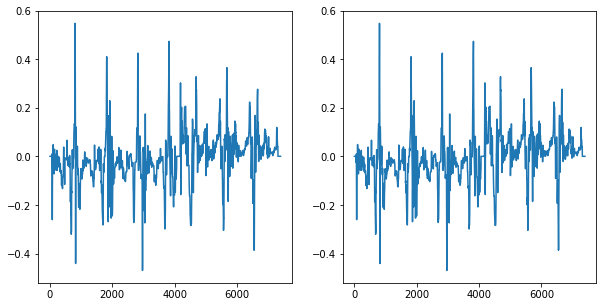

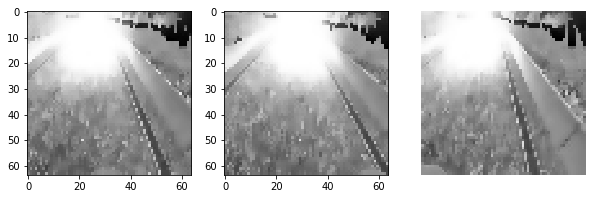

Loaded model from disk
Epoch 1/5
5888/5888 [==============================] - 380s - loss: 0.0365 - val_loss: 0.0068
Epoch 2/5
5888/5888 [==============================] - 374s - loss: 0.0277 - val_loss: 0.0037
Epoch 3/5
5888/5888 [==============================] - 361s - loss: 0.0299 - val_loss: 0.0038
Epoch 4/5
5888/5888 [==============================] - 368s - loss: 0.0261 - val_loss: 0.0035
Epoch 5/5
5888/5888 [==============================] - 360s - loss: 0.0258 - val_loss: 0.0038
Loaded model from disk
Epoch 1/5
5888/5888 [==============================] - 337s - loss: 0.0275 - val_loss: 0.0051
Epoch 2/5
5888/5888 [==============================] - 359s - loss: 0.0240 - val_loss: 0.0037
Epoch 3/5
5888/5888 [==============================] - 373s - loss: 0.0229 - val_loss: 0.0039
Epoch 4/5
5888/5888 [==============================] - 329s - loss: 0.0211 - val_loss: 0.0034
Epoch 5/5
5888/5888 [==============================] - 339s - loss: 0.0173 - val_loss: 0.0039
Loaded model f

In [14]:
directory = "data/Track1.0 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.1, -0.1] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

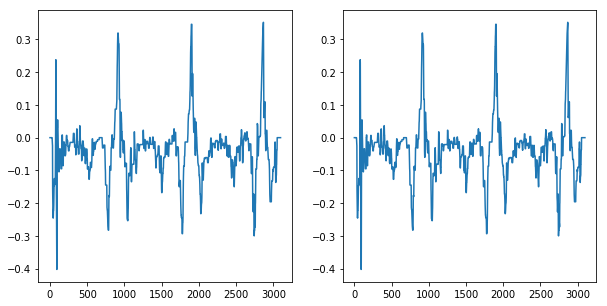

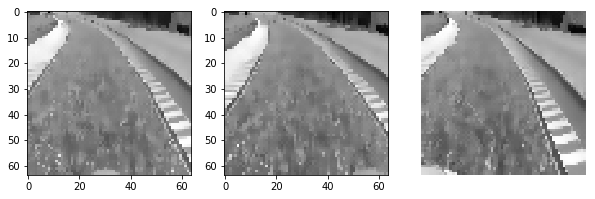

Loaded model from disk
Epoch 1/5
2432/2432 [==============================] - 176s - loss: 0.0184 - val_loss: 0.0059
Epoch 2/5
2432/2432 [==============================] - 176s - loss: 0.0160 - val_loss: 0.0043
Epoch 3/5
2432/2432 [==============================] - 170s - loss: 0.0133 - val_loss: 0.0016
Epoch 4/5
2432/2432 [==============================] - 167s - loss: 0.0143 - val_loss: 0.0015
Epoch 5/5
2432/2432 [==============================] - 167s - loss: 0.0122 - val_loss: 0.0020
Loaded model from disk
Epoch 1/5
2432/2432 [==============================] - 163s - loss: 0.0218 - val_loss: 0.0056
Epoch 2/5
2432/2432 [==============================] - 145s - loss: 0.0168 - val_loss: 0.0034
Epoch 3/5
2432/2432 [==============================] - 150s - loss: 0.0128 - val_loss: 0.0020
Epoch 4/5
2432/2432 [==============================] - 167s - loss: 0.0127 - val_loss: 0.0022
Epoch 5/5
2432/2432 [==============================] - 157s - loss: 0.0163 - val_loss: 0.0019
Loaded model f

In [15]:
directory = "data/Track1.1 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.1, -0.1] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

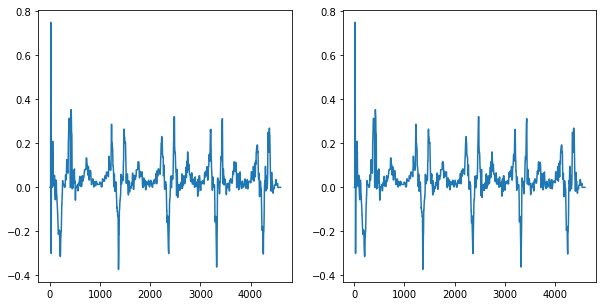

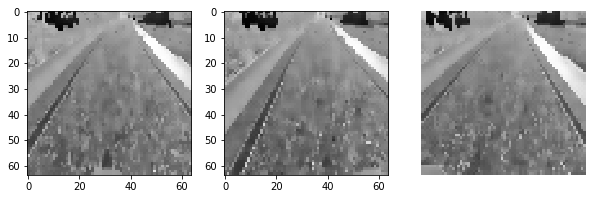

Loaded model from disk
Epoch 1/5
3648/3648 [==============================] - 247s - loss: 0.0182 - val_loss: 0.0033
Epoch 2/5
3648/3648 [==============================] - 239s - loss: 0.0123 - val_loss: 0.0023
Epoch 3/5
3648/3648 [==============================] - 251s - loss: 0.0113 - val_loss: 0.0040
Epoch 4/5
3648/3648 [==============================] - 241s - loss: 0.0079 - val_loss: 0.0025
Epoch 5/5
3648/3648 [==============================] - 244s - loss: 0.0088 - val_loss: 0.0022
Loaded model from disk
Epoch 1/5
3648/3648 [==============================] - 240s - loss: 0.0194 - val_loss: 0.0037
Epoch 2/5
3648/3648 [==============================] - 236s - loss: 0.0120 - val_loss: 0.0037
Epoch 3/5
3648/3648 [==============================] - 216s - loss: 0.0102 - val_loss: 0.0015
Epoch 4/5
3648/3648 [==============================] - 227s - loss: 0.0102 - val_loss: 0.0014
Epoch 5/5
3648/3648 [==============================] - 205s - loss: 0.0083 - val_loss: 0.0014
Loaded model f

In [16]:
directory = "data/Track1.2 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.1, -0.1] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

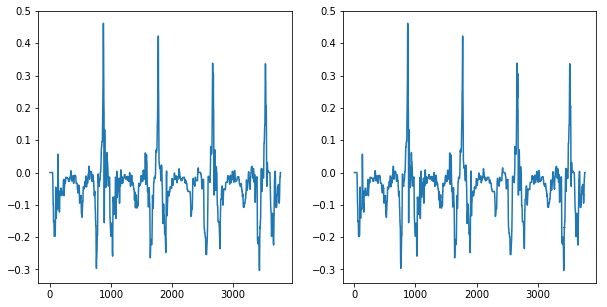

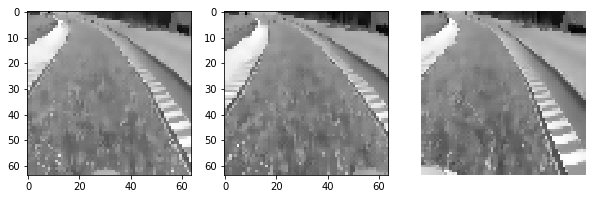

Loaded model from disk
Epoch 1/5
3008/3008 [==============================] - 216s - loss: 0.0101 - val_loss: 0.0019
Epoch 2/5
3008/3008 [==============================] - 196s - loss: 0.0073 - val_loss: 0.0020
Epoch 3/5
3008/3008 [==============================] - 217s - loss: 0.0075 - val_loss: 9.3503e-04
Epoch 4/5
3008/3008 [==============================] - 235s - loss: 0.0077 - val_loss: 0.0012
Epoch 5/5
3008/3008 [==============================] - 227s - loss: 0.0068 - val_loss: 0.0011
Loaded model from disk
Epoch 1/5
3008/3008 [==============================] - 345s - loss: 0.0135 - val_loss: 0.0047
Epoch 2/5
3008/3008 [==============================] - 270s - loss: 0.0084 - val_loss: 0.0019
Epoch 3/5
3008/3008 [==============================] - 225s - loss: 0.0071 - val_loss: 8.7112e-04
Epoch 4/5
3008/3008 [==============================] - 265s - loss: 0.0073 - val_loss: 0.0014
Epoch 5/5
3008/3008 [==============================] - 236s - loss: 0.0049 - val_loss: 9.5024e-04
Lo

In [17]:
directory = "data/Track1.3 - hard"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.1, -0.1] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

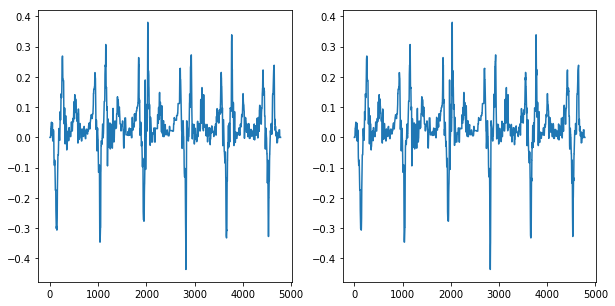

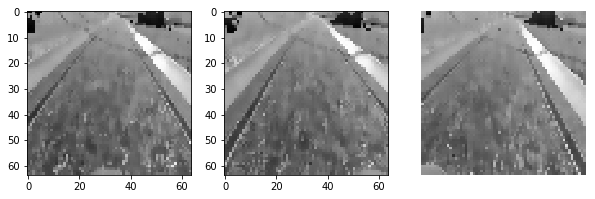

Loaded model from disk
Epoch 1/5
3776/3776 [==============================] - 277s - loss: 0.0195 - val_loss: 0.0030
Epoch 2/5
3776/3776 [==============================] - 273s - loss: 0.0085 - val_loss: 0.0016
Epoch 3/5
3776/3776 [==============================] - 267s - loss: 0.0058 - val_loss: 0.0013
Epoch 4/5
3776/3776 [==============================] - 265s - loss: 0.0057 - val_loss: 0.0012
Epoch 5/5
3776/3776 [==============================] - 265s - loss: 0.0048 - val_loss: 9.7346e-04
Loaded model from disk
Epoch 1/5
3776/3776 [==============================] - 269s - loss: 0.0145 - val_loss: 0.0028
Epoch 2/5
3776/3776 [==============================] - 234s - loss: 0.0071 - val_loss: 0.0012
Epoch 3/5
3776/3776 [==============================] - 243s - loss: 0.0055 - val_loss: 0.0021
Epoch 4/5
3776/3776 [==============================] - 261s - loss: 0.0047 - val_loss: 0.0011
Epoch 5/5
3776/3776 [==============================] - 254s - loss: 0.0054 - val_loss: 0.0010
Loaded mod

In [18]:
directory = "data/Track1.4 - hard"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.1, -0.1] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

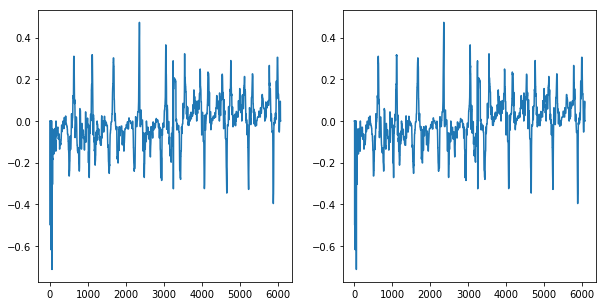

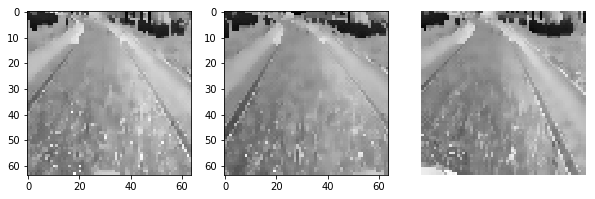

Loaded model from disk
Epoch 1/5
4800/4800 [==============================] - 316s - loss: 0.0066 - val_loss: 0.0032
Epoch 2/5
4800/4800 [==============================] - 317s - loss: 0.0057 - val_loss: 0.0030
Epoch 3/5
4800/4800 [==============================] - 329s - loss: 0.0041 - val_loss: 0.0028
Epoch 4/5
4800/4800 [==============================] - 333s - loss: 0.0042 - val_loss: 0.0026
Epoch 5/5
4800/4800 [==============================] - 321s - loss: 0.0039 - val_loss: 0.0025
Loaded model from disk
Epoch 1/5
4800/4800 [==============================] - 288s - loss: 0.0094 - val_loss: 0.0021
Epoch 2/5
4800/4800 [==============================] - 271s - loss: 0.0047 - val_loss: 0.0016
Epoch 3/5
4800/4800 [==============================] - 270s - loss: 0.0042 - val_loss: 0.0014
Epoch 4/5
4800/4800 [==============================] - 278s - loss: 0.0034 - val_loss: 0.0016
Epoch 5/5
4800/4800 [==============================] - 279s - loss: 0.0030 - val_loss: 0.0013
Loaded model f

In [19]:
directory = "data/Track1.5 - hard"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.1, -0.1] # center, left, right


for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

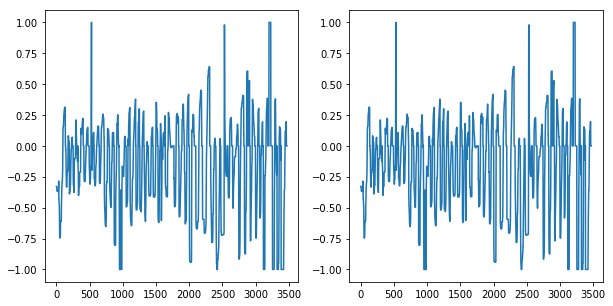

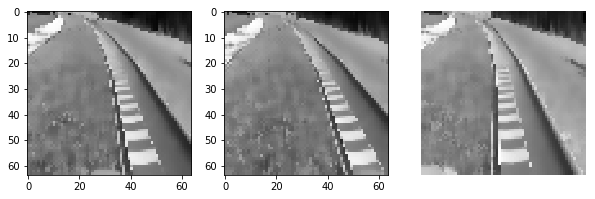

Loaded model from disk
Epoch 1/5
2752/2752 [==============================] - 188s - loss: 0.0930 - val_loss: 0.0948
Epoch 2/5
2752/2752 [==============================] - 164s - loss: 0.0598 - val_loss: 0.0585
Epoch 3/5
2752/2752 [==============================] - 159s - loss: 0.0400 - val_loss: 0.0422
Epoch 4/5
2752/2752 [==============================] - 168s - loss: 0.0316 - val_loss: 0.0357
Epoch 5/5
2752/2752 [==============================] - 192s - loss: 0.0243 - val_loss: 0.0330
Loaded model from disk
Epoch 1/5
2752/2752 [==============================] - 219s - loss: 0.0479 - val_loss: 0.0362
Epoch 2/5
2752/2752 [==============================] - 168s - loss: 0.0333 - val_loss: 0.0334
Epoch 3/5
2752/2752 [==============================] - 188s - loss: 0.0237 - val_loss: 0.0198
Epoch 4/5
2752/2752 [==============================] - 188s - loss: 0.0214 - val_loss: 0.0282
Epoch 5/5
2752/2752 [==============================] - 171s - loss: 0.0182 - val_loss: 0.0210
Loaded model f

In [20]:
directory = "data/Track1.6 - right border"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.1, -0.1] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

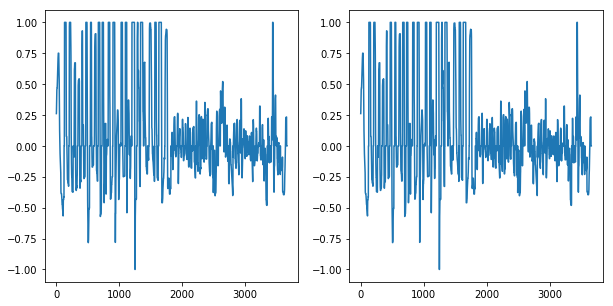

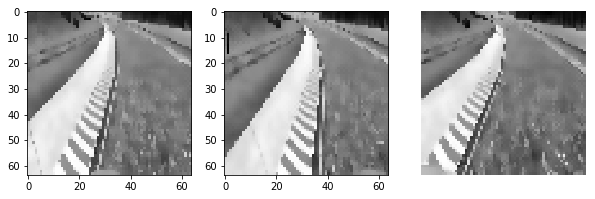

Loaded model from disk
Epoch 1/5
2880/2880 [==============================] - 203s - loss: 0.2063 - val_loss: 0.1610
Epoch 2/5
2880/2880 [==============================] - 169s - loss: 0.1522 - val_loss: 0.1214
Epoch 3/5
2880/2880 [==============================] - 178s - loss: 0.1363 - val_loss: 0.0830
Epoch 4/5
2880/2880 [==============================] - 169s - loss: 0.1192 - val_loss: 0.0844
Epoch 5/5
2880/2880 [==============================] - 174s - loss: 0.0944 - val_loss: 0.0802
We're done


In [12]:
directory = "data/Track1.7 - left border"
csv_lines = load_data(directory)
steering_offsets = [0.0]#, 0.1, -0.1] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

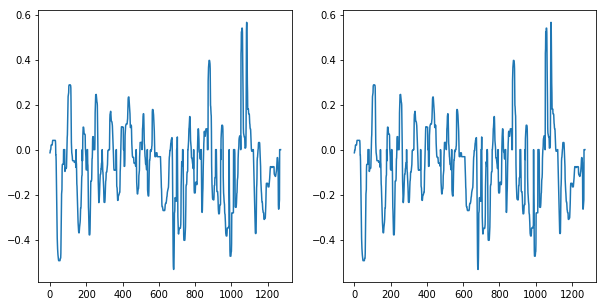

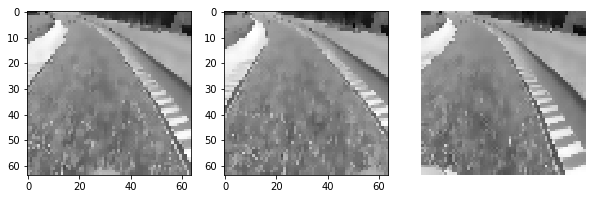

Loaded model from disk
Epoch 1/5
960/960 [==============================] - 87s - loss: 0.0875 - val_loss: 0.0171
Epoch 2/5
960/960 [==============================] - 58s - loss: 0.0620 - val_loss: 0.0185
Epoch 3/5
960/960 [==============================] - 63s - loss: 0.0594 - val_loss: 0.0129
Epoch 4/5
960/960 [==============================] - 72s - loss: 0.0438 - val_loss: 0.0082
Epoch 5/5
960/960 [==============================] - 68s - loss: 0.0416 - val_loss: 0.0117
We're done


In [13]:
directory = "data/Track1.8 - borders"
csv_lines = load_data(directory)
steering_offsets = [0.0]#, 0.1, -0.1] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")